In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv("./churn_prediction_data/train.csv")
test=pd.read_csv("./churn_prediction_data/test.csv")

In [3]:
train["Exited"].value_counts()

0    6368
1    1632
Name: Exited, dtype: int64

## 資料前處理

In [78]:
#ID取前四個數字
train["ID"]=train['CustomerId'].astype(str).str[:5].astype(int)
#將財務商品整合成兩類，大於2個、少於等於2個
train["is_4"]=train['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
#性別數值化(男生0、女生1)
train['Gender']=train['Gender'].apply(lambda x: 1 if x =="male"  else 0)
train["greater than 70000"]=train["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [141]:
#將名字數值化
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Surname'].append(test['Surname']))
train["NAME_ID"]=pd.Series(le.transform(train['Surname']))

In [255]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(train[["Balance","EstimatedSalary"]])
#train["money"] = pca.transform(train[["Balance","EstimatedSalary"]])

PCA(n_components=1)

In [256]:
moneys=pd.DataFrame(pca.transform(train[["Balance","EstimatedSalary"]]),columns=['money1'])

In [257]:
pca.explained_variance_ratio_

array([0.62226845])

In [258]:
pca.n_components_

1

In [259]:
from pylab import mpl
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

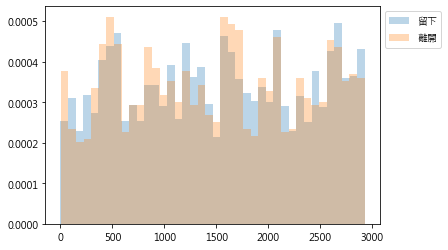

In [260]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40) 
plt.hist(train[train["Exited"]==0]["NAME_ID"], **kwargs,label="留下") 
plt.hist(train[train["Exited"]==1]["NAME_ID"], **kwargs,label="離開") 
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [261]:
#train["is_less_35000"]=train["money"].apply(lambda x: 1 if x <-35000  else 0)

In [262]:
#選擇重要的特徵
select_data=train[["CreditScore","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [263]:
#國家dummy variable
features_dummies=pd.get_dummies(train["Geography"])

In [264]:
#合併資料
#data=select_data
data=pd.concat([select_data, features_dummies,moneys],axis=1)

In [265]:
#標準化
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

data = ss.fit_transform(data)
data = pd.DataFrame(data)

In [266]:
data

,0,1,2,3,4,5,6,7,8,9
0,1.509906,0.339933,0.0,0.966801,-0.663721,0.799546,-1.001501,-0.580814,1.746019,0.438425
1,0.866637,-0.445812,0.0,-1.034339,1.465241,-0.917139,0.998501,-0.580814,-0.572731,-1.195695
2,0.697356,0.339933,0.0,0.966801,-1.595141,-0.917139,0.998501,-0.580814,-0.572731,0.658206
3,-0.656894,-0.445812,0.0,-1.034339,-0.397600,-0.917139,-1.001501,-0.580814,1.746019,0.131566
4,2.068534,0.339933,0.0,0.966801,-0.131480,-0.917139,-1.001501,-0.580814,1.746019,0.664852
...,...,...,...,...,...,...,...,...,...,...
7995,-1.063169,1.125677,0.0,0.966801,-1.062901,0.799546,0.998501,-0.580814,-0.572731,0.684852
7996,-0.487612,1.911421,0.0,-1.034339,0.267700,-0.917139,-1.001501,1.721720,-0.572731,1.437698
7997,0.815853,0.339933,0.0,-1.034339,0.001580,-0.917139,-1.001501,-0.580814,1.746019,1.065481
7998,1.425266,-0.445812,0.0,-1.034339,-0.663721,-0.917139,0.998501,-0.580814,-0.572731,0.570928


## 切訓練集/測試集

In [562]:
#切割資料
train_data,test_data,train_labels,test_labels=train_test_split(data,train["Exited"],test_size=0.01,stratify=train["Exited"])

In [563]:
train_labels = np.array(train_labels)
train_data =  np.array(train_data)
test_labels= np.array(test_labels)
test_data = np.array(test_data)

## 處理資料不平衡(但效果不好，可以跳過

In [116]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_data, train_labels = sm.fit_resample(train_data, train_labels)

In [1175]:
#unique, counts = np.unique(train_labels, return_counts=True)
#dict(zip(unique, counts))

# SVM

In [564]:
from sklearn import svm
clf=svm.SVC(kernel='poly',C=1,gamma='scale',degree=6)
clf.fit(train_data,train_labels)

SVC(C=1, degree=6, kernel='poly')

In [565]:
clf.score(train_data,train_labels)

0.8763888888888889

In [566]:
clf.score(test_data,test_labels)

0.925

<Figure size 432x288 with 0 Axes>

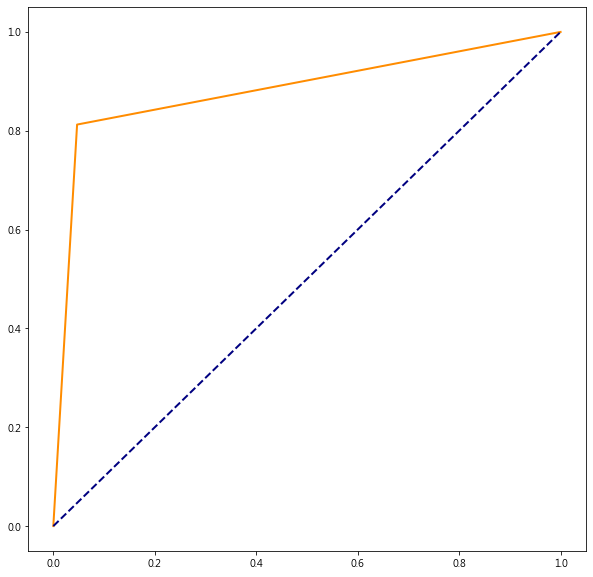

In [567]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, clf.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [568]:
roc_auc

0.8828125

## 利用LightLGB

In [341]:
import lightgbm as lgb
LGB=lgb.LGBMClassifier()
LGB.fit(train_data,train_labels)

LGBMClassifier()

In [342]:
LGB.score(train_data,train_labels)

0.9040404040404041

In [343]:
LGB.score(test_data,test_labels)

0.875

<Figure size 432x288 with 0 Axes>

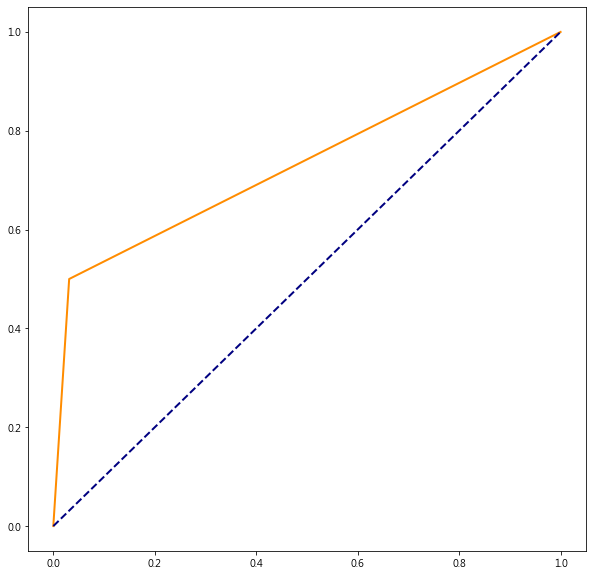

In [344]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, LGB.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [345]:
roc_auc

0.734375

## 交叉應證+選參數

In [26]:
from sklearn.model_selection import KFold,StratifiedKFold,ShuffleSplit
cv=StratifiedKFold(n_splits=5)
cv1=KFold(n_splits=5)
cv2=ShuffleSplit(n_splits=5,test_size=0.1)

In [27]:
from sklearn.model_selection import cross_val_score
scores =cross_val_score(LGB,data,train["Exited"],cv=cv2,scoring='accuracy')
print(scores)

[0.87875 0.86125 0.8525  0.86    0.85375]


In [28]:
fixed_params={'objective': 'binary','metric': 'auc','is_unbalance':True,
              "boosting":'gbdt','num_boost_round':300,'early_stopping_rounds':30}

In [20]:
search_params={"learning_rate":[0.01,0.1,0.3,0.5],'max_depth':[5,10,15,20],
            'num_leaves':[10,20,30,40,50],'feature_fraction':[0.2,0.4,0.6,0.8]}

In [21]:
from sklearn.model_selection import GridSearchCV
#grid=GridSearchCV(lgb.LGBMClassifier(),param_grid=search_params,cv=cv)
#grid.fit(data,train["Exited"])

In [22]:
#grid.score(test_data,test_labels)

In [23]:
#grid.best_params_

In [24]:
#"learning_rate"
from sklearn.model_selection import validation_curve
param=[0.01,0.1,0.3,0.5]
train_scores, test_scores = validation_curve(lgb.LGBMClassifier(), X=data, y=train["Exited"], 
                                             param_name="learning_rate", param_range=param,
                                             cv=cv2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

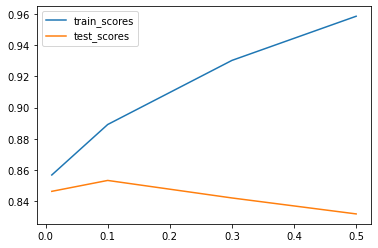

In [25]:
plt.plot(param,train_mean,label="train_scores")
plt.plot(param,test_mean,label="test_scores")
plt.legend(loc="best")

In [26]:
#'max_depth'
from sklearn.model_selection import validation_curve
param=[5,8,10,12,15,20,25]
train_scores, test_scores = validation_curve(lgb.LGBMClassifier(), X=data, y=train["Exited"], 
                                             param_name='max_depth', param_range=param,
                                             cv=cv2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

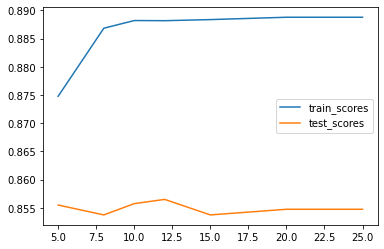

In [27]:
plt.plot(param,train_mean,label="train_scores")
plt.plot(param,test_mean,label="test_scores")
plt.legend(loc="best")

In [28]:
#'num_leaves'
from sklearn.model_selection import validation_curve
param=[5,8,10,12,15,18,20]
train_scores, test_scores = validation_curve(lgb.LGBMClassifier(), X=data, y=train["Exited"], 
                                             param_name='num_leaves', param_range=param,
                                             cv=cv2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

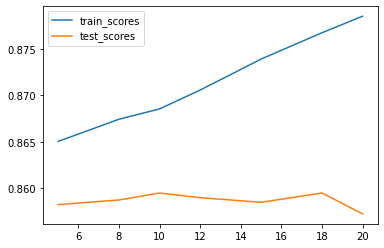

In [29]:
plt.plot(param,train_mean,label="train_scores")
plt.plot(param,test_mean,label="test_scores")
plt.legend(loc="best")

In [30]:
#'feature_fraction'
from sklearn.model_selection import validation_curve
param=[0.1,0.3,0.5,0.7,0.9]
train_scores, test_scores = validation_curve(lgb.LGBMClassifier(), X=data, y=train["Exited"], 
                                             param_name='feature_fraction', param_range=param,
                                             cv=cv2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

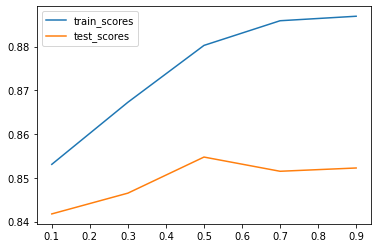

In [31]:
plt.plot(param,train_mean,label="train_scores")
plt.plot(param,test_mean,label="test_scores")
plt.legend(loc="best")

In [32]:
#'subsample'
from sklearn.model_selection import validation_curve
param=[0.1,0.3,0.5,0.7,0.9]
train_scores, test_scores = validation_curve(lgb.LGBMClassifier(), X=data, y=train["Exited"], 
                                             param_name='subsample', param_range=param,
                                             cv=cv2)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

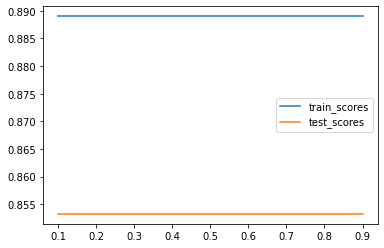

In [33]:
plt.plot(param,train_mean,label="train_scores")
plt.plot(param,test_mean,label="test_scores")
plt.legend(loc="best")

## 利用MLPClassifier

In [34]:
from sklearn.neural_network import MLPClassifier
MLP= MLPClassifier(max_iter=100, activation='relu', solver='adam')
MLP.fit(train_data,train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [35]:
MLP.score(train_data,train_labels)

0.80890625

In [36]:
MLP.score(test_data,test_labels)

0.80625

<Figure size 432x288 with 0 Axes>

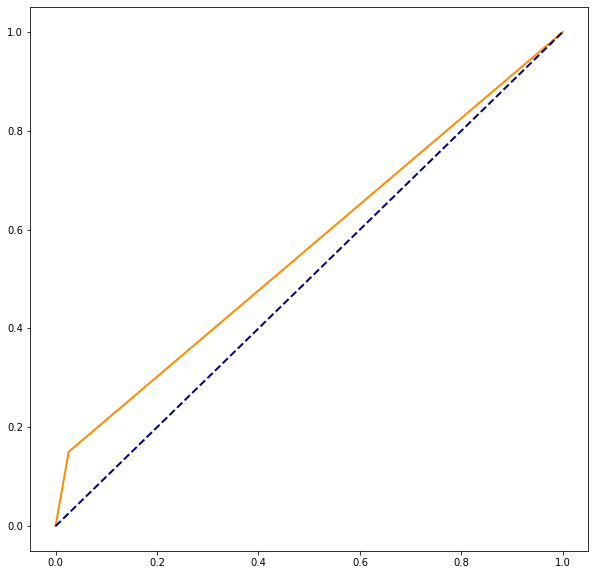

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr,tpr,threshold =roc_curve(test_labels, MLP.predict(test_data))
roc_auc = auc(fpr,tpr) ###計算auc的值 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.show()

In [38]:
roc_auc

0.562202039853223

## test資料預測

In [569]:
#test資料前處理
test["ID"]=test['CustomerId'].astype(str).str[:4].astype(int)
test["is_4"]=test['NumOfProducts'].apply(lambda x: 1 if x >2  else 0)
test["NAME_ID"]=pd.Series(le.transform(test['Surname']))
test['Gender']=test['Gender'].apply(lambda x: 1 if x =="male"  else 0)
test["greater than 70000"]=test["Balance"].apply(lambda x: 1 if x >70000  else 0)

In [570]:
#PCA轉換
moneys1=pd.DataFrame(pca.transform(test[["Balance","EstimatedSalary"]]),columns=['money1'])

In [348]:
#test["is_less_35000"]=test["money"].apply(lambda x: 1 if x <-35000  else 0)

In [571]:
#特徵選擇
select_data=test[["CreditScore","Tenure","Gender","IsActiveMember",'Age','NumOfProducts']]

In [572]:
#特徵dummy
features_dummies=pd.get_dummies(test["Geography"])

In [573]:
#合併資料
data1=pd.concat([select_data, features_dummies,moneys1],axis=1)

In [574]:
#標準化
data1 = ss.fit_transform(data1)
data1 = pd.DataFrame(data1)

In [575]:
data1

,0,1,2,3,4,5,6,7,8,9
0,1.609183,-1.222346,0.0,-1.016130,-0.508456,-0.889646,0.992032,-0.570422,-0.578120,-1.264331
1,0.528128,-1.222346,0.0,-1.016130,-0.112514,-0.889646,0.992032,-0.570422,-0.578120,0.950381
2,-1.401138,1.184637,0.0,0.984126,-1.168361,0.841183,0.992032,-0.570422,-0.578120,-1.301884
3,1.692341,-1.222346,0.0,-1.016130,-0.112514,-0.889646,-1.008032,-0.570422,1.729744,-0.440669
4,-1.600717,1.184637,0.0,0.984126,0.943333,-0.889646,0.992032,-0.570422,-0.578120,-1.225020
...,...,...,...,...,...,...,...,...,...,...
1995,-0.020715,1.184637,0.0,0.984126,-1.036380,0.841183,0.992032,-0.570422,-0.578120,-1.277772
1996,0.162233,0.382309,0.0,-1.016130,-0.244495,0.841183,-1.008032,1.753089,-0.578120,-0.108153
1997,-1.351243,-1.222346,0.0,0.984126,0.415410,0.841183,0.992032,-0.570422,-0.578120,0.575458
1998,-0.453136,1.986964,0.0,0.984126,0.151448,0.841183,-1.008032,-0.570422,1.729744,-1.234582


In [576]:
#預測結果
clf.predict(data1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [577]:
sum(clf.predict(data1))/2000

0.1115

In [330]:
#預測結果
LGB.predict(data1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [331]:
#預測為1的比例
sum(LGB.predict(data1))/2000

0.138

## 匯出資料

In [578]:
#lgb
d = {"RowNumber":test.RowNumber,"Exited":clf.predict(data1)}
df = pd.DataFrame(d)
df.to_csv("./output/svm7.csv")

In [680]:
pd.Series(clf.predict(data1)).value_counts()

0    1796
1     204
dtype: int64

In [333]:
#lgb
d = {"RowNumber":test.RowNumber,"Exited":LGB.predict(data1)}
df = pd.DataFrame(d)
df.to_csv("./output/LightLGB25.csv")

In [1338]:
pd.Series(LGB.predict(data1)).value_counts()

0    1714
1     286
dtype: int64

In [54]:
#結果解讀
f1=0.6061
precise=0.7018
recall=f1*precise/(2*precise-f1)

In [55]:
print("預估正的,真正為正的機率",precise)
print("真正為正的，預估正的確率",recall)

預估正的,真正為正的機率 0.7018
真正為正的，預估正的確率 0.533368


In [56]:
264*precise #預估跟真正都是正的

185.27519999999998

In [58]:
264*precise/recall #全部正的

347.36842105263156

In [59]:
(264*precise/recall)/2000

0.17368421052631577

In [706]:
#拿過去資料預測的資料，來投票
data_1=pd.read_csv("./output/LightLGB18.csv")
data_2=pd.read_csv("./output/LightLGB23.csv")
data_3=pd.read_csv("./output/svm5.csv")
data_4=pd.read_csv("./output/LightLGB17.csv")
data_5=pd.read_csv("./output/LightLGB16.csv")
data_6=pd.read_csv("./output/combine34.csv")
data_7=pd.read_csv("./output/LightLGB22.csv")
data_8=pd.read_csv("./output/LightLGB25.csv")


In [707]:
a=data_1["Exited"]+data_2["Exited"]+data_3["Exited"]+data_4["Exited"]+data_5["Exited"]+data_6["Exited"]+data_7["Exited"]+data_8["Exited"]

In [708]:
a.value_counts()

0    1622
8     184
1      45
2      36
3      28
7      26
4      22
6      22
5      15
Name: Exited, dtype: int64

In [709]:
a[a<8]=0
a[a>7]=1

In [710]:
sum(a)/2000

0.092

In [711]:
d = {"RowNumber":test.RowNumber,"Exited":a}
df = pd.DataFrame(d)
df.to_csv("./output/combine37.csv")